# Introduction

The objective of our Modeling is to create an Image Classification model to predict what food it is, given the image of an Indian food. We'll be utilizing PyTorch Pretrained models for the Classification and Kaggle for the dataset.

## Loading the Data

In [4]:
# installing kaggle API, split_folders
!pip install opendatasets --upgrade --quiet
!pip install split-folders --quiet

In [5]:
# importing libraries

import opendatasets as od
import numpy as np
import splitfolders
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [6]:
# loading dataset from Kaggle API
dataset_url = "https://www.kaggle.com/l33tc0d3r/indian-food-classification"
od.download(dataset_url)

100%|██████████| 1.48G/1.48G [00:15<00:00, 101MB/s]


This dataset has 20 folders for 20 classes containing 6271 images of Indian food.

In [7]:
import os

DATA_DIR = './indian-food-classification/Food Classification'
classes = os.listdir(DATA_DIR)
classes

['pav_bhaji',
 'fried_rice',
 'chapati',
 'pizza',
 'jalebi',
 'samosa',
 'masala_dosa',
 'burger',
 'paani_puri',
 'dhokla',
 'butter_naan',
 'pakode',
 'momos',
 'idli',
 'chai',
 'kulfi',
 'kadai_paneer',
 'kaathi_rolls',
 'dal_makhani',
 'chole_bhature']

In [8]:
print(os.listdir(DATA_DIR + '/pav_bhaji')[:10])

['121.jpg', '164.jpg', '172.jpg', '237.jpg', '290.jpg', '344.jpg', '152.jpg', '214.jpg', '049.jpg', '219.jpg']


## Making new Folders for train-test-val split

From Kaggle, we were able to get a dataset cleanly split into its 20 classes. However, we can't operate on it as is and hence, we need to split them into train, test and validation sets.

In [9]:
!mkdir indian-food-classification/dataset

In [10]:
input_folder = DATA_DIR
output_folder = './indian-food-classification/dataset'
splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.7, 0.2, 0.1), # train, val, test split
                   group_prefix = None)

Copying files: 6271 files [00:38, 164.76 files/s]


## Applying Data Transforms and getting Data Loaders

In [11]:
# Data Transforms (Normalization & Data augmentation)
img_size = 224
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = tt.Compose([tt.Resize(224),
                         tt.Pad(8, padding_mode='reflect'), 
                         tt.RandomCrop(img_size),
                         # tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate(),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize(224),
                         tt.Pad(8, padding_mode='reflect'), 
                         tt.RandomCrop(img_size),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

In [12]:
# PyTorch datasets
train_ds = ImageFolder(output_folder+'/train', train_tfms)
valid_ds = ImageFolder(output_folder+'/val', valid_tfms)

In [13]:
# PyTorch data loaders

batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, pin_memory=True)

# Exploratory Data Analysis

In [14]:
len(train_dl), len(valid_dl)

(35, 5, 3)

In [15]:
# looking at one batch of images after denormalizing

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

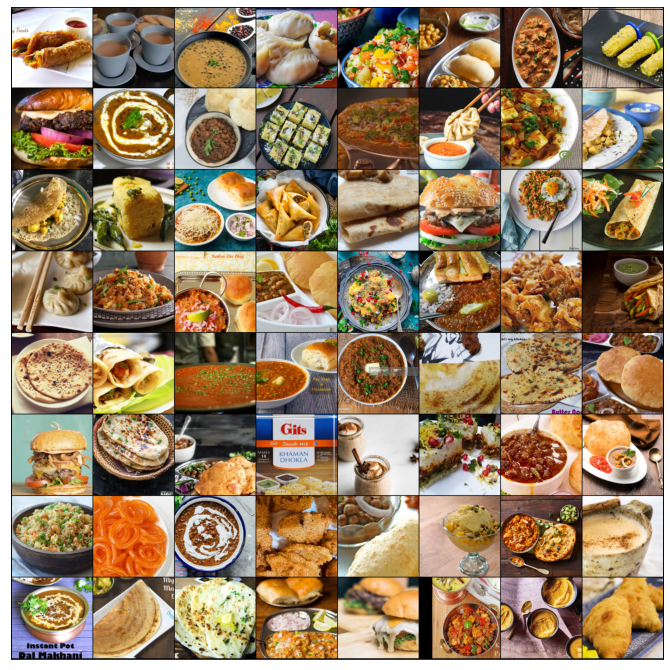

In [16]:
show_batch(train_dl)

3 x 224 x 224 size images

# Modeling

## Defining Generic methods for all Deep Learning Models with GPU Usage and Image Classification task

In [17]:
# Moving both Data and Model into GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [20]:
# Defining our generic Base Class for any Image Classification task

import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

## Finetuning ResNet50
20 epochs : OneCycleLR Scheduler: **88% Accuracy**

### Defining Network Architecture

In [21]:
# Defining our finetuned Resnet50 Architecture with our Classification layer

from torchvision import models

class IndianFoodModelResnet50(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [22]:
models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training, evaluation and LR functions

In [23]:
# defining train, eval and lr functions

import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
# initialising our model and moving it to GPU
model = IndianFoodModelResnet50(len(classes), pretrained=True)
to_device(model, device);

In [26]:
# testing our model with zero training on the Validation Data
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.05426520109176636, 'val_loss': 3.0902798175811768}]

### Picking hyperparameters and Training the Model

In [ ]:
# hyperparameters 
epochs = 20
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam    

In [ ]:
# training the model
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                  weight_decay, grad_clip, opt_func)

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1],last_lr: 0.00010, train_loss: 2.0605, val_loss: 0.8558, val_acc: 0.7886


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00028, train_loss: 0.5348, val_loss: 0.5247, val_acc: 0.8549


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00052, train_loss: 0.3943, val_loss: 1.2075, val_acc: 0.6896


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00076, train_loss: 0.6589, val_loss: 2.2253, val_acc: 0.5154


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00094, train_loss: 0.6038, val_loss: 1.5165, val_acc: 0.6384


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00100, train_loss: 0.6804, val_loss: 1.7128, val_acc: 0.6371


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00099, train_loss: 0.4852, val_loss: 1.0657, val_acc: 0.7255


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00095, train_loss: 0.3972, val_loss: 0.9496, val_acc: 0.7506


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00089, train_loss: 0.3469, val_loss: 1.5500, val_acc: 0.6701


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00081, train_loss: 0.2806, val_loss: 0.7126, val_acc: 0.8004


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00072, train_loss: 0.1974, val_loss: 0.7958, val_acc: 0.7864


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00061, train_loss: 0.1468, val_loss: 0.5851, val_acc: 0.8379


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00050, train_loss: 0.0892, val_loss: 0.5507, val_acc: 0.8640


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00039, train_loss: 0.0601, val_loss: 0.4954, val_acc: 0.8822


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00028, train_loss: 0.0346, val_loss: 0.4780, val_acc: 0.8886


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00019, train_loss: 0.0179, val_loss: 0.4536, val_acc: 0.8849


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00011, train_loss: 0.0123, val_loss: 0.4713, val_acc: 0.8888


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00005, train_loss: 0.0092, val_loss: 0.4967, val_acc: 0.8798


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00001, train_loss: 0.0131, val_loss: 0.4477, val_acc: 0.8956


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [20],last_lr: 0.00000, train_loss: 0.0132, val_loss: 0.4634, val_acc: 0.8870
CPU times: user 1h 3min 47s, sys: 10min 32s, total: 1h 14min 20s
Wall time: 1h 14min 13s


### Plotting Graphs for Accuracy, Losses, Epochs and Batches

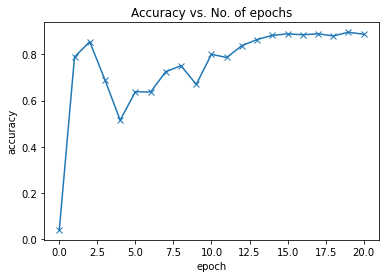

In [ ]:
# Accuracy vs Epochs
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

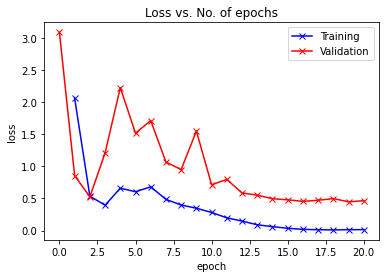

In [ ]:
# Train, Val Loss vs Epochs
def plot_losses(history):
    x1,x2,y1,y2 = plt.axis()  
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.axis((2,12,0,4))
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

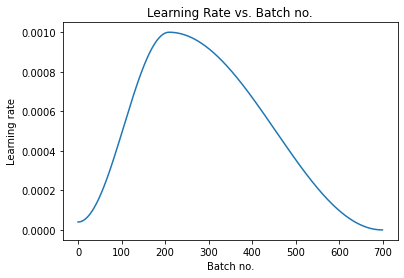

In [ ]:
# Learning Rate vs Batches
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

### Saving Model Weights

In [ ]:
# saving the model
torch.save(model.state_dict(), 'indianFood-resnet50.pth')

### Loading Model Weights

In [38]:
# loading the model
ckp_path = './indianFood-resnet50.pth'
model2 = IndianFoodModelResnet50(len(classes), pretrained=True)
model2 = to_device(model2, device)
model2.load_state_dict(torch.load(ckp_path))

<All keys matched successfully>

In [39]:
# sanity checking so the test set retains previous accuracy
evaluate(model2, valid_dl)

{'val_acc': 0.8957489132881165, 'val_loss': 0.4256541430950165}

### Making Predictions on Individual Samples

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: burger , Predicted: burger


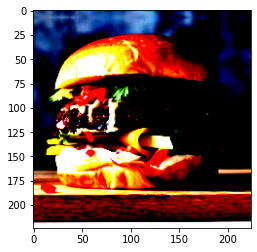

In [42]:
# predicting label on an image from our Val Data
img, label = valid_ds[0] 
plt.imshow(img.permute(1, 2, 0).clamp(0, 1)) # permuting image to push channel dim to the end
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

Label: dal_makhani , Predicted: kadai_paneer


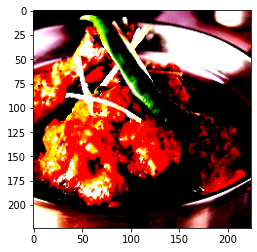

In [43]:
# predicting label on an image from our Val Data
img, label = valid_ds[420] 
plt.imshow(img.permute(1, 2, 0).clamp(0, 1)) # permuting image to push channel dim to the end
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

Label: butter_naan , Predicted: butter_naan


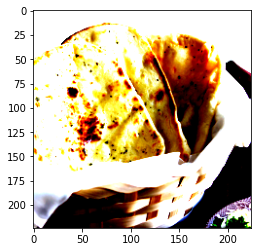

In [44]:
# predicting label on an image from our Val Data
img, label = valid_ds[66] 
plt.imshow(img.permute(1, 2, 0).clamp(0, 1)) # permuting image to push channel dim to the end
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

Label: chapati , Predicted: chapati


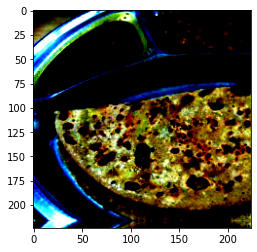

In [45]:
# predicting label on an image from our Val Data
img, label = valid_ds[222] 
plt.imshow(img.permute(1, 2, 0).clamp(0, 1)) # permuting image to push channel dim to the end
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

### Evaluating on the Test Dataset

We have to transform our Raw Test Data according to model specifications before passing them for predictions.

In [51]:
# resizing and normalizing test data to fit the model
test_tfms = tt.Compose([tt.Resize((224, 224)),
                        tt.ToTensor(), 
                        tt.Normalize(*stats, inplace = True)])

# PyTorch Dataset
test_ds = ImageFolder(output_folder+'/test', test_tfms)

# PyTorch Data Loader
test_dl = DataLoader(test_ds, batch_size*2, pin_memory=True)

In [52]:
# moving test data to GPU, model is already on GPU
test_dl = DeviceDataLoader(test_dl, device)

Label: kadai_paneer , Predicted: kadai_paneer


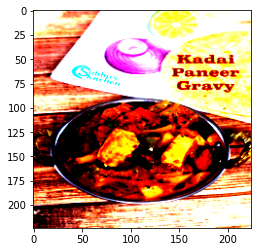

In [59]:
# sampling an image from the test set
img, label = test_ds[420] 
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

In [53]:
# testing our model on the Test Data
test_res = [evaluate(model2, test_dl)]
test_res

[{'val_acc': 0.9006937146186829, 'val_loss': 0.419871985912323}]

We see that we get an accuracy of **90%** on our raw Test Dataset.

### Recording Metrics

- model = ResNet50
- batch_size = 128
- LR scheduler = OneCycle LR
- epochs = 20
- max_lr = 0.001
- grad_clip = 0.1
- weight_decay = 1e-4
- opt_func = torch.optim.Adam  
---
1. Test Accuracy: 90%
2. Test Loss: 0.420

## Trying out Other Models

We tested out multiple models. The findings are below:
- `ResNet34` achieved 80% Accuracy with 10 epochs.
- `AlexNet` achieved 63% Accuracy with 10 epochs and a fixed Learning Rate.
- `DenseNet` did not fit into the memory of Colab due to its large size.
- `ResNet101` and `ResNet152` also did not fit into the limited memory of Colab.

### Finetuning ResNet34 - 80% Acc

In [ ]:
# Resnet34 Model

from torchvision import models

class IndianFoodModelResnet(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
models.resnet34(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = IndianFoodModelResnet(len(classes), pretrained=True)
to_device(model, device);

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.05701013654470444, 'val_loss': 3.248394727706909}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                  weight_decay, grad_clip, opt_func)

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1],last_lr: 0.00272, train_loss: 1.1922, val_loss: 18.0740, val_acc: 0.1608


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00756, train_loss: 1.6319, val_loss: 12.8650, val_acc: 0.1086


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.01000, train_loss: 1.6386, val_loss: 3.2637, val_acc: 0.2028


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00950, train_loss: 1.2829, val_loss: 2.4150, val_acc: 0.3498


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00812, train_loss: 1.1551, val_loss: 1.7238, val_acc: 0.5166


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00611, train_loss: 0.8720, val_loss: 1.0729, val_acc: 0.6874


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00389, train_loss: 0.8110, val_loss: 1.5350, val_acc: 0.5838


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00188, train_loss: 0.5627, val_loss: 0.8425, val_acc: 0.7571


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00050, train_loss: 0.3800, val_loss: 0.7271, val_acc: 0.7949


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00000, train_loss: 0.3014, val_loss: 0.6797, val_acc: 0.7992
CPU times: user 30min 13s, sys: 2min 32s, total: 32min 46s
Wall time: 32min 44s


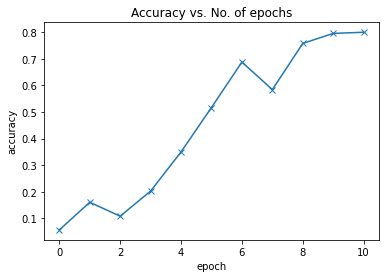

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

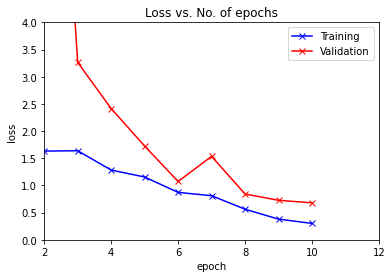

In [ ]:
def plot_losses(history):
    x1,x2,y1,y2 = plt.axis()  
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.axis((2,12,0,4))
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

- Resnet34: 80% acc in 10 epochs

### Finetuning Alexnet - 63% Acc

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Alexnet Model

from torchvision import models

class IndianFoodModelAlexnet(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.alexnet(pretrained=pretrained)
        # Replace last layer
        self.network.classifier[6] = nn.Linear(self.network.classifier[6].in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
models.alexnet(pretrained=True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model = IndianFoodModelAlexnet(len(classes), pretrained=True)
to_device(model, device);

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.05173845961689949, 'val_loss': 3.270397901535034}]

In [ ]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit(epochs, max_lr, model, train_dl, valid_dl, opt_func)

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


Epoch [1], train_loss: 2.8313, val_loss: 2.9082, val_acc: 0.1350


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.4899, val_loss: 2.3405, val_acc: 0.2774


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.1102, val_loss: 2.0088, val_acc: 0.4045


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.9394, val_loss: 1.8201, val_acc: 0.4323


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.7634, val_loss: 1.7854, val_acc: 0.4588


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.5917, val_loss: 1.8068, val_acc: 0.4850


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.4176, val_loss: 1.6812, val_acc: 0.5045


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.3348, val_loss: 1.3404, val_acc: 0.6017


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1747, val_loss: 1.4117, val_acc: 0.5843


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.1401, val_loss: 1.3177, val_acc: 0.6357
CPU times: user 28min 17s, sys: 35.7 s, total: 28min 52s
Wall time: 28min 45s


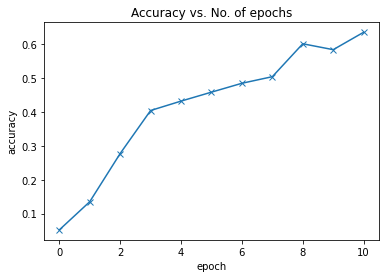

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

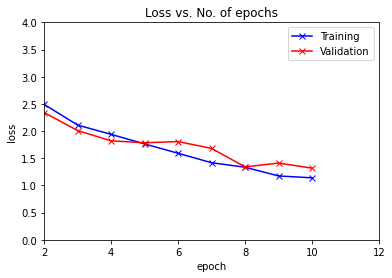

In [ ]:
def plot_losses(history):
    x1,x2,y1,y2 = plt.axis()  
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.axis((2,12,0,4))
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

### Finetuning DenseNet - Did not fit in Memory

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Alexnet Model

from torchvision import models

class IndianFoodModelDensenet(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet169(pretrained=pretrained)
        # Replace last layer
        self.network.classifier = nn.Linear(self.network.classifier.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
models.densenet169(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model = IndianFoodModelDensenet(len(classes), pretrained=True)
to_device(model, device);

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.05083052068948746, 'val_loss': 3.0747246742248535}]

In [ ]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit(epochs, max_lr, model, train_dl, valid_dl, opt_func)

  0%|          | 0/35 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    x1,x2,y1,y2 = plt.axis()  
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.axis((2,12,0,4))
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

DenseNet did not fit in memory.

## Hyperparameters and Regularization

- We are not carrying out hyperparameter tuning to due our variable LR scheduler in the model and the limitations of ResNet.
- Most of the meaningful Regularization techniques was incorporated in the beginning itself so we are not adding any more of that.

# Conclusion

1. We successfully accomplished our objective of applying a Deep Learning model to solve a real-life problem of identifying various Indian food, given their images. The finetuned ResNet model achieved a `90% Accuracy` on the Test Set, which is pretty good.
2. Future work is deploying this model to a webapp so it can give prediction on any image uploaded by the public.